# LoRA Implementation

Original Paper:  https://arxiv.org/pdf/2106.09685.pdf

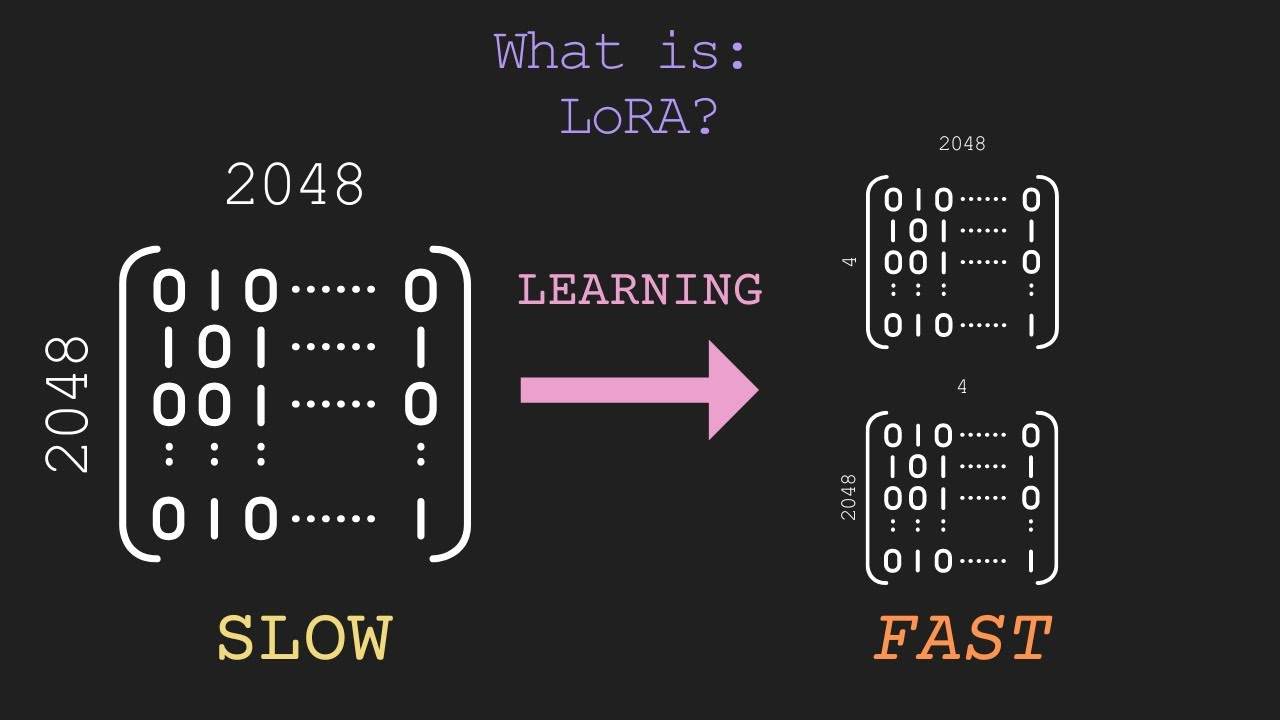

#### Install Dependencies

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.7 MB/s eta 0:00:00


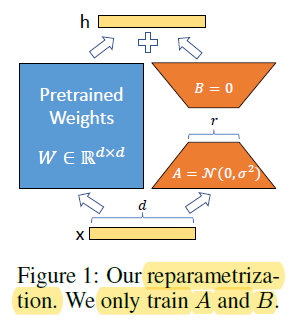

#### Confirm CUDA

In [ ]:
import torch
torch.cuda.is_available()

True

#### Load Base Model

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM


#bloom-3b ->3B params,  bloom-1b7 ->1.72B params
model = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloom-1b7",
    torch_dtype=torch.float16,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("bigscience/tokenizer")

##### View Model Summary

In [ ]:
print(model)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 2048)
    (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (

for llama - projq, projv

In [ ]:
#some pre-processing
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

#### Helper Function

In [ ]:
#see how many param lora reduce
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Obtain LoRA Model

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,      #rank
    lora_alpha=16,  #double of rank
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 1572864 || all params: 1723981824 || trainable%: 0.09123437254985815


#### Load Sample Dataset

In [ ]:
from datasets import load_dataset

qa_dataset = load_dataset("squad_v2")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

```
### CONTEXT
{context}

### QUESTION
{question}

### ANSWER
{answer}</s>
```

In [ ]:
def create_prompt(context, question, answer):
  if len(answer["text"]) < 1:
    answer = "Cannot Find Answer"
  else:
    answer = answer["text"][0]
  prompt_template = f"### CONTEXT\n{context}\n\n### QUESTION\n{question}\n\n### ANSWER\n{answer}</s>"
  return prompt_template

mapped_qa_dataset = qa_dataset.map(lambda samples: tokenizer(create_prompt(samples['context'], samples['question'], samples['answers'])))

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Trainer Docs :  https://huggingface.co/docs/transformers/main_classes/trainer

#### Train LoRA

In [ ]:
import transformers

trainer = transformers.Trainer(
    model=model,
    train_dataset=mapped_qa_dataset["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=100,
        learning_rate=1e-3,
        fp16=True,
        logging_steps=1,
        output_dir='outputs',
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,3.037100
2,2.987300
3,2.987100
4,3.199600
5,3.164100
6,3.064700
7,2.900300
8,3.108500
9,3.190400
10,3.128600


TrainOutput(global_step=100, training_loss=2.666443877220154, metrics={'train_runtime': 384.9546, 'train_samples_per_second': 4.156, 'train_steps_per_second': 0.26, 'total_flos': 2980788492632064.0, 'train_loss': 2.666443877220154, 'epoch': 0.01})

In [3]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.1 MB/s eta 0:00:00


In [4]:
HUGGING_FACE_USER_NAME = "Asher"

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
# for pushing Model to the HUB
model_name = "squad-bloom-17b"

model.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)

NameError: ignored

the model size is 6mb now

In [7]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = f"{HUGGING_FACE_USER_NAME}/{model_name}"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path, device_map='auto')

# Load the Lora model
qa_model = PeftModel.from_pretrained(model, peft_model_id)


In [8]:
qa_model = qa_model.to("cuda")

In [12]:
from IPython.display import display, Markdown

def make_inference(context, question):
  batch = tokenizer(f"### CONTEXT\n{context}\n\n### QUESTION\n{question}\n\n### ANSWER\n", return_tensors='pt').to("cuda")
  # don't forget to pass the tokenised input to cuda


  with torch.cuda.amp.autocast():
    output_tokens = qa_model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [13]:
import torch
torch.cuda.is_available()

True

In [14]:
context = "Cheese is the best food."
question = "What is the best food?"

make_inference(context, question)

### CONTEXT
Cheese is the best food.

### QUESTION
What is the best food?

### ANSWER
Cheese

In [15]:
context = "Cheese is the best food."
question = "How far away is the Moon from the Earth?"

make_inference(context, question)

### CONTEXT
Cheese is the best food.

### QUESTION
How far away is the Moon from the Earth?

### ANSWER
3.5 million miles

In [16]:
context = "The Moon orbits Earth at an average distance of 384,400 km (238,900 mi), or about 30 times Earth's diameter. Its gravitational influence is the main driver of Earth's tides and very slowly lengthens Earth's day. The Moon's orbit around Earth has a sidereal period of 27.3 days. During each synodic period of 29.5 days, the amount of visible surface illuminated by the Sun varies from none up to 100%, resulting in lunar phases that form the basis for the months of a lunar calendar. The Moon is tidally locked to Earth, which means that the length of a full rotation of the Moon on its own axis causes its same side (the near side) to always face Earth, and the somewhat longer lunar day is the same as the synodic period. However, 59% of the total lunar surface can be seen from Earth through cyclical shifts in perspective known as libration."
question = "At what distance does the Moon orbit the Earth?"

make_inference(context, question)

### CONTEXT
The Moon orbits Earth at an average distance of 384,400 km (238,900 mi), or about 30 times Earth's diameter. Its gravitational influence is the main driver of Earth's tides and very slowly lengthens Earth's day. The Moon's orbit around Earth has a sidereal period of 27.3 days. During each synodic period of 29.5 days, the amount of visible surface illuminated by the Sun varies from none up to 100%, resulting in lunar phases that form the basis for the months of a lunar calendar. The Moon is tidally locked to Earth, which means that the length of a full rotation of the Moon on its own axis causes its same side (the near side) to always face Earth, and the somewhat longer lunar day is the same as the synodic period. However, 59% of the total lunar surface can be seen from Earth through cyclical shifts in perspective known as libration.

### QUESTION
At what distance does the Moon orbit the Earth?

### ANSWER
238,900 mi

In [ ]:
marketmail_model = PeftModel.from_pretrained(model, "c-s-ale/bloom-7b1-marketmail-ai")

In [ ]:
from IPython.display import display, Markdown

def make_inference_mm_ai(product, description):
  batch = tokenizer(f"Below is a product and description, please write a marketing email for this product.\n\n### Product:\n{product}\n### Description:\n{description}\n\n### Marketing Email:\n", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = marketmail_model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
your_product_name_here = "The Coolinator"
your_product_description_here = "A personal cooling device to keep you from getting overheated on a hot summer's day!"

make_inference_mm_ai(your_product_name_here, your_product_description_here)